
# Fraud Detection in Financial Transactions

**Course:** IT5022 - Fundamentals of Machine Learning (MSc AI)  
**Student:** MS25948592 — N.G.S.D. Nanayakkara  
**Dataset:** [Fraudulent Transactions Data (Kaggle)](https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data)

**Models:** Logistic Regression (baseline, interpretable) & Random Forest (nonlinear, robust)

> This notebook is optimized for large data (≈6.3M rows). If your machine has limited RAM, enable **QUICK_EXPERIMENT** to downsample while preserving fraud cases.


In [125]:

# If you need to install missing packages, uncomment and run:
# !pip install pandas numpy scikit-learn matplotlib plotly imbalanced-learn polars


## Imports

In [126]:
# === Standard library
from pathlib import Path
import os
import gc
import zipfile
import warnings

# === Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Optional: Polars (if you want faster CSV ops); safe fallback if missing
try:
    import polars as pl
    POLARS_AVAILABLE = True
except Exception:
    POLARS_AVAILABLE = False

# === Scikit-learn
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

# --- Reproducibility & plotting defaults
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

# Optional: silence overly chatty warnings in notebooks
warnings.filterwarnings("ignore", category=UserWarning)


## Configuration

In [127]:
# =========================
# Configuration & Data Load
# =========================
# Why QUICK_EXPERIMENT?
# - On 8GB RAM, full 6.3M rows can be heavy (EDA + encoding + modeling).
# - QUICK_EXPERIMENT caps rows for faster iteration; flip to False for final runs on a stronger machine.
QUICK_EXPERIMENT = True
MAX_ROWS = 500_000      # cap used later when loading (speed + memory safety)

# Why a time-aware cutoff?
# - Train on earlier 'step' values and test on later ones to avoid temporal leakage and simulate production.
TRAIN_CUTOFF_STEP = 600

# Local data directory (not committed to git; add to .gitignore)
DATA_DIR = Path("./data")
DATA_DIR.mkdir(exist_ok=True)

# Preferred default filename if present (some Kaggle mirrors/package variants use different names)
CSV_FILENAME = "Fraud.csv"
csv_path = DATA_DIR / CSV_FILENAME

def _find_csv_after_download(data_dir: Path) -> Path | None:
    """
    Find a usable CSV inside data_dir after download/extract.
    Kaggle mirrors/package variants commonly ship one of:
      - Fraud.csv
      - fraudTrain.csv / fraudTest.csv
      - PS_20174392719_1491204439457_log.csv (older/original name)
    Strategy:
      1) Prefer known names in priority order.
      2) Otherwise, pick the largest CSV (likely the main dataset).
    """
    preferred = [
        "Fraud.csv",
        "fraudTrain.csv",
        "PS_20174392719_1491204439457_log.csv"
    ]
    for name in preferred:
        p = data_dir / name
        if p.exists():
            return p

    # Fallback: pick the largest CSV in the folder
    csvs = list(data_dir.glob("*.csv"))
    if not csvs:
        return None
    return max(csvs, key=lambda p: p.stat().st_size)

def _kaggle_available() -> bool:
    """Check if Kaggle CLI is available on PATH."""
    return shutil.which("kaggle") is not None

def _download_from_kaggle(data_dir: Path) -> None:
    """
    Download + extract the dataset using Kaggle CLI.
    NOTE: Requires Kaggle authentication:
      - Place kaggle.json under ~/.kaggle/ (Linux/macOS) or %USERPROFILE%\\.kaggle\\ (Windows)
      - Get it from https://www.kaggle.com/account -> Create New API Token
    """
    print("Attempting Kaggle download…")
    # -d <owner/dataset> ; -p <path> place zip under ./data
    rc = os.system("kaggle datasets download -d chitwanmanchanda/fraudulent-transactions-data -p data")
    if rc != 0:
        print("⚠️ Kaggle CLI returned a non-zero status. Verify Kaggle is installed & authenticated.")
        return

    # Extract all zips downloaded to data/
    for z in data_dir.glob("*.zip"):
        try:
            with zipfile.ZipFile(z, "r") as zip_ref:
                zip_ref.extractall(data_dir)
        finally:
            z.unlink(missing_ok=True)  # clean up zip either way

# -----------------
# Locate the CSV(s)
# -----------------
if not csv_path.exists():
    print(f"CSV '{CSV_FILENAME}' not found in {DATA_DIR.resolve()}")

    # Try Kaggle download if CLI exists
    if _kaggle_available():
        _download_from_kaggle(DATA_DIR)
    else:
        print("⚠️ Kaggle CLI not found on PATH. Install via `pip install kaggle` and configure kaggle.json,")
        print("   or manually place the dataset CSV into the ./data folder.")

    # After download/extract (or manual copy), try to resolve the actual CSV path
    resolved = _find_csv_after_download(DATA_DIR)
    if resolved is None:
        raise FileNotFoundError(
            "No CSV found in ./data. Please ensure the dataset is downloaded/extracted correctly."
        )

    CSV_FILENAME = resolved.name
    csv_path = resolved
    print(f"✅ Using dataset file: {csv_path.name}")
else:
    print("✅ CSV already exists:", csv_path.name)

# At this point:
# - `csv_path` points to the dataset file we will load.
# - `CSV_FILENAME` holds its name (useful for logging).
# - QUICK_EXPERIMENT / MAX_ROWS guide the loader later.


✅ CSV already exists: Fraud.csv


## Load Data (Memory–Aware)

In [128]:
def read_data_pandas(
    path: Path,
    quick_experiment: bool = False,
    max_rows: int | None = None,
) -> pd.DataFrame:
    """
    Load the Fraudulent Transactions dataset with memory-efficient dtypes.

    Args:
        path: pathlib.Path to the CSV file (e.g., DATA_DIR / CSV_FILENAME).
        quick_experiment: If True, limit rows for faster iteration on low-RAM machines.
        max_rows: Row cap used when quick_experiment=True (e.g., 500_000).

    Returns:
        DataFrame with enforced dtypes and only expected columns.

    Notes:
        - 'category' for string/id columns → big memory savings.
        - numeric floats as float32; labels as int8.
        - We pass `usecols` to lock schema and avoid surprise columns.
        - `low_memory=False` prevents mixed dtypes on large files.
    """
    if not path.exists():
        raise FileNotFoundError(
            f"❌ CSV not found at: {path}. "
            f"Expected under {DATA_DIR.resolve()}/{CSV_FILENAME}."
        )

    dtype_map = {
        "step": "int32",
        "type": "category",
        "amount": "float32",
        "nameOrig": "category",
        "oldbalanceOrg": "float32",
        "newbalanceOrig": "float32",
        "nameDest": "category",
        "oldbalanceDest": "float32",
        "newbalanceDest": "float32",
        "isFraud": "int8",
        "isFlaggedFraud": "int8",
    }
    usecols = list(dtype_map.keys())

    # Pandas load (dtype-locked, schema-locked). If quick mode, cap rows.
    read_kwargs = dict(
        usecols=usecols,
        dtype=dtype_map,
        low_memory=False,
        engine="c",
    )
    if quick_experiment and max_rows is not None:
        read_kwargs["nrows"] = int(max_rows)

    df = pd.read_csv(path, **read_kwargs)

    # Report basic info + memory footprint (helpful on 8GB machines)
    mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
    print(f"✅ Loaded {len(df):,} rows x {df.shape[1]} cols from '{path.name}' "
          f"(~{mem_mb:.1f} MB in-memory)")

    # Quick schema guard: ensure no unexpected object columns slipped through
    leftover_objects = [c for c in df.columns if df[c].dtype == "object"]
    if leftover_objects:
        raise TypeError(f"Unexpected object dtypes after enforced load: {leftover_objects}")

    return df


# ---- Example usage in notebook ----
csv_path = DATA_DIR / CSV_FILENAME  # <- Pathlib, not os.path.join
df = read_data_pandas(
    csv_path,
    quick_experiment=QUICK_EXPERIMENT,
    max_rows=MAX_ROWS
)

print("Columns:", df.columns.tolist())
df.head()


✅ Loaded 500,000 rows x 11 cols from 'Fraud.csv' (~81.4 MB in-memory)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.0,160296.359375,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.0,19384.720703,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.000000,C1305486145,181.0,0.000000,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.000000,C840083671,181.0,0.000000,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.0,29885.859375,M1230701703,0.0,0.0,0,0


## Exploratory Data Analysis (EDA)

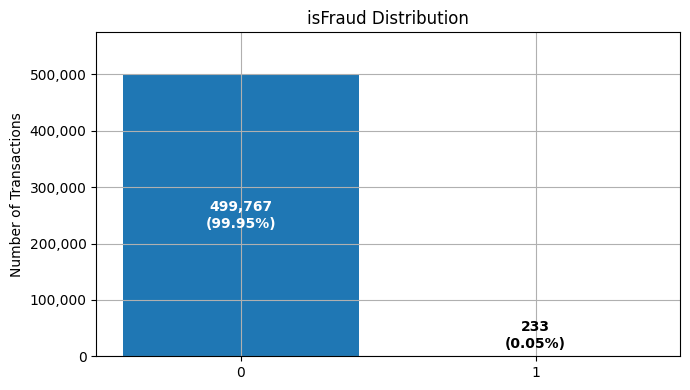

In [129]:
# Counts & percentages (lock order to 0,1 if present)
counts = df['isFraud'].value_counts().sort_index()
percentages = (counts / counts.sum()) * 100

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(range(len(counts)), counts.values)  # default colors are fine/legible

ax.set_title("isFraud Distribution")
ax.set_ylabel("Number of Transactions")
ax.set_xticks(range(len(counts)))
ax.set_xticklabels([str(c) for c in counts.index])

# y-axis with thousands separator
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Annotate: inside for majority, above for tiny bars; auto pad ylim if needed
max_count = counts.max()
placed_above = False

for i, (bar, count, pct) in enumerate(zip(bars, counts.values, percentages.values)):
    label = f"{count:,}\n({pct:.2f}%)"
    x = bar.get_x() + bar.get_width() / 2

    if pct > 1.0 and count > 0:  # majority → place inside with contrast
        ax.text(x, count * 0.5, label, ha='center', va='center',
                fontsize=10, color='white', fontweight='bold')
    else:  # minority → place slightly above the bar
        ax.text(x, count + max_count * 0.02, label, ha='center', va='bottom',
                fontsize=10, color='black', fontweight='bold')
        placed_above = True

# give headroom if we placed any label above bars
if placed_above:
    ax.set_ylim(0, max_count * 1.15)

plt.tight_layout()
plt.show()


### 🎯 Class Distribution (Target – `isFraud`)
- The dataset is extremely imbalanced: ~99.87% non-fraud vs ~0.13% fraud.
- Accuracy will not be a useful metric (a model predicting only "0" would reach ~99%).
- **Action:** Focus on ROC-AUC, PR-AUC, and precision/recall trade-offs.
- Apply class weighting instead of oversampling to avoid memory issues.

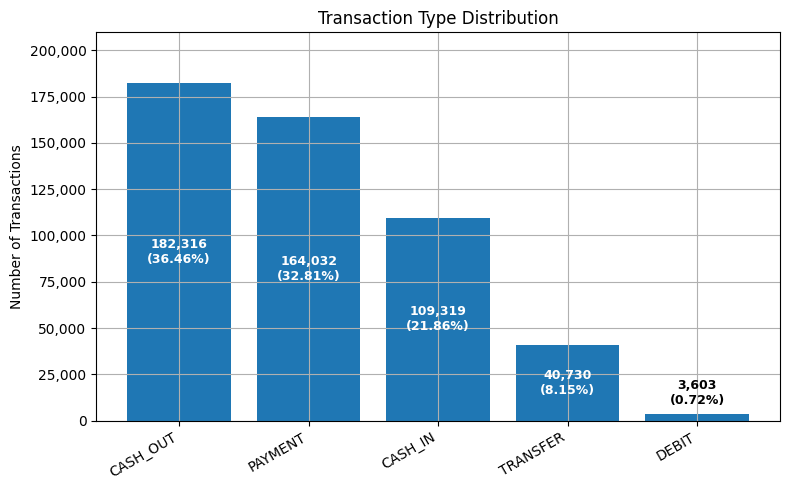

In [130]:
# Counts & percentages (keep them aligned)
counts = df["type"].value_counts()                 # ordered by frequency
percentages = (counts / counts.sum()) * 100        # aligned with counts' index
cats = counts.index.tolist()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(range(len(cats)), counts.values)  # default color = clear & consistent

ax.set_title("Transaction Type Distribution")
ax.set_ylabel("Number of Transactions")
ax.set_xticks(range(len(cats)))
ax.set_xticklabels([str(c) for c in cats], rotation=30, ha="right")

# y-axis with thousands separator
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

max_count = counts.max()
placed_above = False

# Annotate: inside for large categories, above for small ones
for i, (bar, count, pct) in enumerate(zip(bars, counts.values, percentages.values)):
    label = f"{count:,}\n({pct:.2f}%)"
    x = bar.get_x() + bar.get_width() / 2

    if pct > 5.0 and count > 0:
        ax.text(x, count * 0.5, label, ha='center', va='center',
                fontsize=9, color='white', fontweight='bold')
    else:
        ax.text(x, count + max_count * 0.02, label, ha='center', va='bottom',
                fontsize=9, color='black', fontweight='bold')
        placed_above = True

# Give headroom if any labels were placed above bars
if placed_above:
    ax.set_ylim(0, max_count * 1.15)

plt.tight_layout()
plt.show()


### 📂 Transaction Type (`type`)
- CASH_OUT (~35%) and PAYMENT (~34%) dominate the dataset.
- Fraud is often linked to specific transaction types (CASH_OUT, TRANSFER).
- **Action:** Encode `type` with One-Hot Encoding.
- Later, analyze fraud prevalence by type to check predictive strength.

In [131]:
# Build summary
n_rows = len(df)
mem_bytes = df.memory_usage(deep=True)

numeric_cols = df.select_dtypes(include=["float32","float64","int32","int64","int8","uint8"]).columns

summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": n_rows - df.isna().sum(),
    "null_count": df.isna().sum(),
    "null_pct": (df.isna().mean() * 100).round(2),
    "n_unique": df.nunique(dropna=True),
    "mem_mb": (mem_bytes / (1024**2)).round(3)
}).reset_index().rename(columns={"index": "column"})

# Min/Max only for numeric columns
num_stats = df[numeric_cols].agg(["min","max"]).T.rename(columns={"min":"min", "max":"max"})
summary = summary.merge(
    num_stats.reset_index().rename(columns={"index":"column"}),
    on="column", how="left"
)

# Order columns for readability
summary = summary[["column","dtype","non_null","null_count","null_pct","n_unique","min","max","mem_mb"]]
summary = summary.sort_values(["null_pct","column"], ascending=[False, True]).reset_index(drop=True)

print("🧹 Data Quality Summary")
print(f"Total rows: {n_rows:,} | Total memory: ~{(mem_bytes.sum()/(1024**2)):.1f} MB")

def _fmt(x):
    if isinstance(x, float):
        return f"{x:,.2f}"
    if isinstance(x, int):
        return f"{x:,}"
    return x

try:
    # Stylish display (Jupyter)
    def highlight_nulls(s):
        return ["background-color: #ffe6e6" if v > 0 else "" for v in s]

    display(
        summary.style
        .format({"null_pct":"{:.2f}%", "mem_mb":"{:.3f}", "min":"{:,}", "max":"{:,}"})
        .apply(highlight_nulls, subset=["null_count","null_pct"])
    )
except Exception:
    # Fallback: plain print
    display(summary.map(_fmt))


🧹 Data Quality Summary
Total rows: 500,000 | Total memory: ~81.4 MB


,column,dtype,non_null,null_count,null_pct,n_unique,min,max,mem_mb
0,amount,float32,"500,000.00",0.00,0.00,"491,084.00",0.10,"10,000,000.00",1.91
1,isFlaggedFraud,int8,"500,000.00",0.00,0.00,1.00,0.00,0.00,0.48
2,isFraud,int8,"500,000.00",0.00,0.00,2.00,0.00,1.00,0.48
3,nameDest,category,"500,000.00",0.00,0.00,"214,856.00",nan,nan,22.16
4,nameOrig,category,"500,000.00",0.00,0.00,"499,953.00",nan,nan,46.39
5,newbalanceDest,float32,"500,000.00",0.00,0.00,"167,995.00",0.00,"41,482,696.00",1.91
6,newbalanceOrig,float32,"500,000.00",0.00,0.00,"224,864.00",0.00,"38,946,232.00",1.91
7,oldbalanceDest,float32,"500,000.00",0.00,0.00,"291,748.00",0.00,"41,482,696.00",1.91
8,oldbalanceOrg,float32,"500,000.00",0.00,0.00,"229,634.00",0.00,"38,939,424.00",1.91
9,step,int32,"500,000.00",0.00,0.00,20.00,1.00,20.00,1.91


### 🧹 Data Quality
- No missing values in any column.
- Dtypes are already optimized (`int32`, `float32`, `category`).
- **Action:** No imputation needed; proceed with feature engineering.

## Data sanity & schema lock

### ✅ Schema Validation & Dtype Enforcement
We harden the pipeline by verifying required columns, warning on extras, enforcing dtypes, and validating binary targets. This prevents silent schema drift and mixed dtypes that can break preprocessing/modeling later.

In [132]:
EXPECTED_COLS = {
    "step","type","amount","nameOrig","oldbalanceOrg","newbalanceOrig",
    "nameDest","oldbalanceDest","newbalanceDest","isFraud","isFlaggedFraud"
}

DTYPE_MAP = {
    "step": "int32",
    "type": "category",
    "amount": "float32",
    "nameOrig": "category",
    "oldbalanceOrg": "float32",
    "newbalanceOrig": "float32",
    "nameDest": "category",
    "oldbalanceDest": "float32",
    "newbalanceDest": "float32",
    "isFraud": "int8",
    "isFlaggedFraud": "int8",
}

def enforce_schema(df: pd.DataFrame,
                   expected_cols: set[str] = EXPECTED_COLS,
                   dtype_map: dict[str, str] = DTYPE_MAP) -> pd.DataFrame:
    """
    Validate presence of expected columns, warn on extras, and enforce dtypes.
    Also validates that `isFraud`/`isFlaggedFraud` are binary (0/1).
    """
    df = df.copy()

    # 1) Column presence
    missing = expected_cols - set(df.columns)
    extra   = set(df.columns) - expected_cols
    if missing:
        raise ValueError(f"❌ Missing expected columns: {sorted(missing)}")
    if extra:
        print(f"⚠️ Extra columns present (will be retained): {sorted(extra)}")

    # 2) Enforce dtypes (fail fast on invalid casts)
    for c, t in dtype_map.items():
        if t == "category":
            df[c] = df[c].astype("category")
        else:
            # Ensure numeric before final cast to narrower type
            df[c] = pd.to_numeric(df[c], errors="raise").astype(t)

    # 3) Validate binary targets
    for bcol in ("isFraud", "isFlaggedFraud"):
        uniq = set(pd.Series(df[bcol]).dropna().unique().tolist())
        if not uniq.issubset({0, 1}):
            raise ValueError(f"❌ Column '{bcol}' must be binary 0/1; found values {sorted(uniq)}")

    # 4) No stray object columns (all strings are category by design)
    bad_object_cols = [c for c in df.columns if df[c].dtype == "object"]
    if bad_object_cols:
        raise TypeError(f"❌ Unexpected object dtypes after enforcement: {bad_object_cols}")

    print("✅ Schema & dtypes validated.")
    return df

# Apply schema enforcement
df = enforce_schema(df)


✅ Schema & dtypes validated.


## Feature Engineering

### ⚙️ Feature Engineering (Consolidated)

We add business-rule features (balance deltas), anomaly cues (ratios, flags), a log scale for `amount`, and **encode `type`**. We also drop high-cardinality IDs that do not generalize.
- **Why:** These encode balance consistency, unusually large amounts, and domain knowledge (fraud concentrates in `CASH_OUT`/`TRANSFER`).


In [133]:
def add_engineered_features(df: pd.DataFrame) -> tuple[pd.DataFrame, list[str], list[str]]:
    """
    Add engineered features for fraud detection (NO one-hot here).
    Leaves the raw 'type' column intact for the Pipeline's OneHotEncoder.

    Adds:
      - Balance deltas (consistency checks)
      - Ratios (amount vs balances) with safe divide
      - Flags (negative balances, no-change despite amount, high-risk types)
      - Log-transformed amount

    Returns
    -------
    df_out : pd.DataFrame
        Copy of df with engineered features and sanitized numeric types.
    numeric_feats : list[str]
        Names of numeric features to feed into ColumnTransformer.
    categorical_feats : list[str]
        Names of categorical features (e.g., ['type']) to feed into ColumnTransformer.
    """
    import numpy as np
    df = df.copy()

    required = [
        "step", "type", "amount",
        "oldbalanceOrg", "newbalanceOrig",
        "oldbalanceDest", "newbalanceDest"
    ]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    # --- Cast core numerics to float32 for memory efficiency ---
    for c in ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]:
        df[c] = df[c].astype("float32")

    # --- Balance deltas ---
    # origin consistency (amount should explain drop in origin balance)
    df["tx_delta_orig"] = (df["oldbalanceOrg"] - df["newbalanceOrig"] - df["amount"]).astype("float32")
    # destination change
    df["tx_delta_dest"] = (df["newbalanceDest"] - df["oldbalanceDest"]).astype("float32")

    # --- Ratios (safe divide) ---
    # amount / oldbalanceOrg
    denom = df["oldbalanceOrg"]
    num   = df["amount"]
    df["orig_balance_ratio"] = np.divide(
        num, denom, out=np.zeros_like(num, dtype="float32"), where=(denom > 0)
    ).astype("float32")

    # amount / oldbalanceDest
    denom = df["oldbalanceDest"]
    df["dest_balance_ratio"] = np.divide(
        num, denom, out=np.zeros_like(num, dtype="float32"), where=(denom > 0)
    ).astype("float32")

    # --- Flags (compact int8) ---
    df["flag_orig_negative"] = (df["newbalanceOrig"] < 0).astype("int8")
    df["flag_dest_negative"] = (df["newbalanceDest"] < 0).astype("int8")
    df["flag_orig_nochange"] = ((df["oldbalanceOrg"] == df["newbalanceOrig"]) & (df["amount"] > 0)).astype("int8")
    df["flag_dest_nochange"] = ((df["oldbalanceDest"] == df["newbalanceDest"]) & (df["amount"] > 0)).astype("int8")

    # Domain flag: high-risk types (TRANSFER, CASH_OUT)
    if "type" in df.columns:
        df["flag_high_risk_type"] = df["type"].isin(["CASH_OUT", "TRANSFER"]).astype("int8")
    else:
        df["flag_high_risk_type"] = np.int8(0)

    # --- Log transform ---
    df["log_amount"] = np.log1p(df["amount"]).astype("float32")

    # --- Drop high-cardinality IDs if present (model doesn't need them) ---
    df.drop(columns=["nameOrig", "nameDest"], inplace=True, errors="ignore")

    # --- Sanitize numeric infinities / NaNs ---
    num_cols = df.select_dtypes(include=["float32", "float64"]).columns
    if not np.isfinite(df[num_cols].to_numpy()).all():
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
    if df[num_cols].isna().any().any():
        df[num_cols] = df[num_cols].fillna(0.0)

    # --- Feature lists for the pipeline ---
    numeric_feats = [
        "step", "amount",
        "oldbalanceOrg", "newbalanceOrig",
        "oldbalanceDest", "newbalanceDest",
        "tx_delta_orig", "tx_delta_dest",
        "orig_balance_ratio", "dest_balance_ratio",
        "flag_orig_negative", "flag_dest_negative",
        "flag_orig_nochange", "flag_dest_nochange",
        "flag_high_risk_type",
        "log_amount",
    ]
    categorical_feats = ["type"]  # keep raw; OneHotEncoder will handle it

    # Final guard: ensure 'type' is string/categorical (not object mixed with numbers)
    df["type"] = df["type"].astype("string")

    return df, numeric_feats, categorical_feats


# Apply
df, numeric_feats, categorical_feats = add_engineered_features(df)
print("✅ Engineered features added. Current shape:", df.shape)
print("Numeric feats:", len(numeric_feats), "| Categorical feats:", categorical_feats)


✅ Engineered features added. Current shape: (500000, 19)
Numeric feats: 16 | Categorical feats: ['type']


## Time-Aware Train/Test Split

### ⏱️ Time-Aware Split

We train on early periods and test on later periods to **avoid leakage** and simulate production. We also verify that both splits contain positive (`isFraud=1`) cases.


In [134]:
import numpy as np
import pandas as pd
from typing import Tuple

def time_aware_split(
    df: pd.DataFrame,
    cutoff: int | float,
    target_col: str = "isFraud",
    gap_steps: int = 0,
    verbose: bool = True,
    *,
    auto_adjust: bool = True,
    min_pos_each: int = 1,
    min_rows_each: int = 1,
    ensure_sorted: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame, int]:
    """
    Time-aware split using 'step' to avoid leakage.

    Train: step <= cutoff
    Gap  : (cutoff, cutoff + gap_steps]  (excluded from both)
    Test : step  > cutoff + gap_steps

    If the split is invalid (empty side or no positives) and auto_adjust=True,
    the function searches for the nearest feasible cutoff that yields valid splits.

    Parameters
    ----------
    df : pd.DataFrame
        Input frame containing 'step' and the target column.
    cutoff : int | float
        Desired step boundary. The function will auto-adjust to a feasible step if needed.
    target_col : str
        Name of the binary target column (0/1).
    gap_steps : int
        Number of steps to skip after the cutoff to create a temporal gap.
    verbose : bool
        Print a summary of the split.
    auto_adjust : bool
        If True, search near the requested cutoff for a feasible boundary when invalid.
    min_pos_each : int
        Minimum number of positive samples required on each side.
    min_rows_each : int
        Minimum number of rows required on each side.
    ensure_sorted : bool
        If True, sort outputs by 'step' for legibility (no impact on logic).

    Returns
    -------
    (df_train, df_test, used_cutoff)
    """
    required = {"step", target_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    # Make a working copy; ensure numeric 'step'
    work = df.copy()
    if not np.issubdtype(work["step"].dtype, np.number):
        work["step"] = pd.to_numeric(work["step"], errors="raise")

    cutoff = float(cutoff)
    gap_steps = int(max(gap_steps, 0))

    def _split_with_cutoff(_df: pd.DataFrame, c: float, gap: int):
        train_mask = _df["step"] <= c
        gap_end = c + gap
        test_mask = _df["step"] > gap_end
        gap_mask = (~train_mask) & (~test_mask)
        dtr = _df.loc[train_mask].copy()
        dte = _df.loc[test_mask].copy()
        return dtr, dte, gap_mask, float(c), float(gap_end)

    def _valid(dtr: pd.DataFrame, dte: pd.DataFrame) -> bool:
        return (
            (len(dtr) >= min_rows_each) and (len(dte) >= min_rows_each) and
            (int(dtr[target_col].sum()) >= min_pos_each) and
            (int(dte[target_col].sum()) >= min_pos_each)
        )

    # First try the requested cutoff
    df_train, df_test, gap_mask, used_c, gap_end = _split_with_cutoff(work, cutoff, gap_steps)

    # Auto-adjust if invalid
    if not _valid(df_train, df_test):
        if not auto_adjust:
            raise ValueError(
                "Invalid time split (empty side or no positives). "
                "Enable auto_adjust=True or change cutoff/gap."
            )

        # Aggregate by step; search near requested cutoff for a feasible boundary
        g = (work.groupby("step", observed=True)[target_col]
                 .agg(n="size", pos="sum")
                 .reset_index()
                 .sort_values("step"))
        steps = g["step"].to_numpy(dtype=float)
        n = g["n"].to_numpy(dtype=int)
        pos = g["pos"].to_numpy(dtype=int)
        if len(steps) < 2:
            raise ValueError("Not enough distinct 'step' values to perform a time-aware split.")

        pos_cum = pos.cumsum()
        n_cum = n.cumsum()
        total_pos = pos.sum()
        total_n = n.sum()

        idx = np.searchsorted(steps, cutoff, side="right") - 1
        idx = max(0, min(idx, len(steps) - 2))  # keep room on right side

        best_idx = None
        for radius in range(len(steps)):
            for cand in (idx - radius, idx + radius):
                if cand < 0 or cand >= len(steps) - 1:
                    continue
                pos_left  = int(pos_cum[cand])
                pos_right = int(total_pos - pos_cum[cand])
                n_left    = int(n_cum[cand])
                n_right   = int(total_n - n_cum[cand])
                if (
                    pos_left  >= min_pos_each and pos_right >= min_pos_each and
                    n_left    >= min_rows_each and n_right   >= min_rows_each
                ):
                    best_idx = cand
                    break
            if best_idx is not None:
                break

        if best_idx is None:
            raise ValueError(
                "Could not find a cutoff with required positives/rows on both sides. "
                "Increase data coverage, lower min_pos_each/min_rows_each, or reduce gap."
            )

        used_c = float(steps[best_idx])
        df_train, df_test, gap_mask, used_c, gap_end = _split_with_cutoff(work, used_c, gap_steps)
        if not _valid(df_train, df_test):
            raise ValueError(
                "Auto-adjusted cutoff still yields invalid split. "
                "Try reducing gap_steps or relaxing constraints."
            )

    # Verifiability: temporal purity assertions
    if len(df_train) == 0 or len(df_test) == 0:
        raise AssertionError("Temporal split produced an empty side.")
    assert df_train["step"].max() <= used_c, "Train contains steps after the cutoff."
    assert df_test["step"].min() > gap_end, "Test contains steps not strictly after cutoff+gap."

    if ensure_sorted:
        df_train = df_train.sort_values("step").reset_index(drop=True)
        df_test  = df_test.sort_values("step").reset_index(drop=True)

    if verbose:
        tr_min, tr_max = int(df_train["step"].min()), int(df_train["step"].max())
        te_min, te_max = int(df_test["step"].min()), int(df_test["step"].max())
        tr_pos = int(df_train[target_col].sum()); te_pos = int(df_test[target_col].sum())
        tr_rate = df_train[target_col].mean();    te_rate = df_test[target_col].mean()
        print(f"✅ Train: {df_train.shape} | steps [{tr_min}, {tr_max}] | positives={tr_pos:,} ({tr_rate:.4%})")
        if gap_steps > 0:
            gap_rows = int((~((work['step'] <= used_c) | (work['step'] > gap_end))).sum())
            print(f"⛔ Gap  : {gap_rows:,} rows excluded (steps ({used_c}, {gap_end}])")
        print(f"✅ Test : {df_test.shape}  | steps [{te_min}, {te_max}] | positives={te_pos:,} ({te_rate:.4%})")
        print(f"🔗 Used cutoff step: {used_c:g} | Gap: {gap_steps}")
    return df_train, df_test, int(used_c)

df_train, df_test, USED_CUTOFF = time_aware_split(
    df,
    cutoff=TRAIN_CUTOFF_STEP,
    gap_steps=0,          # or >0 to introduce a temporal gap
    auto_adjust=True,     # will move to nearest feasible step if needed
    min_pos_each=1,       # keep >= 1 fraud on each side
    min_rows_each=1,
    ensure_sorted=True,
    verbose=True
)

✅ Train: (492483, 19) | steps [1, 19] | positives=231 (0.0469%)
✅ Test : (7517, 19)  | steps [20, 20] | positives=2 (0.0266%)
🔗 Used cutoff step: 19 | Gap: 0


## Feature/target separation & scaling plan

### 🧱 Feature/Target Setup & Scaling Plan

- **Target:** `isFraud`
- **Scaling:** Only continuous numeric features are standardized (mean=0, std=1). Binary flags and one-hot dummies are passed through untouched (keeps interpretability and avoids unnecessary transforms).
- **Why:** Logistic Regression is sensitive to feature scales; tree models are not.


In [135]:
# Build X/y from RAW columns; preprocessing/encoding happen in your Pipeline
feature_cols = numeric_feats + categorical_feats

X_train = df_train[feature_cols].copy()
y_train = df_train["isFraud"].astype("int8").values

X_test  = df_test[feature_cols].copy()
y_test  = df_test["isFraud"].astype("int8").values

# Ensure categoricals are strings for OHE
for c in categorical_feats:
    X_train[c] = X_train[c].astype("string")
    X_test[c]  = X_test[c].astype("string")

assert X_train["step"].max() <= USED_CUTOFF
assert X_test["step"].min()  >  USED_CUTOFF  # (or > USED_CUTOFF + gap_steps if you set a gap)

## Logistic Regression pipeline with ColumnTransformer

### 📈 Logistic Regression (Pipeline)

We use a `ColumnTransformer` to **scale only the continuous features** and pass through the rest. The model uses `class_weight="balanced"` to handle the extreme class imbalance. We evaluate using **ROC-AUC** and **PR-AUC** (more informative under imbalance), plus confusion matrix and a classification report.


✅ Logistic Regression — Evaluation
ROC-AUC : 0.9890
PR-AUC  : 0.1061
Threshold used: 0.9695

Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9993    0.9996      7515
           1     0.1667    0.5000    0.2500         2

    accuracy                         0.9992      7517
   macro avg     0.5833    0.7497    0.6248      7517
weighted avg     0.9996    0.9992    0.9994      7517



,model,threshold,precision,recall,f1,roc_auc,pr_auc,tp,fp,fn,tn
0,Logistic Regression (Pipeline),0.969498,0.166667,0.5,0.25,0.989022,0.106135,1,5,1,7510


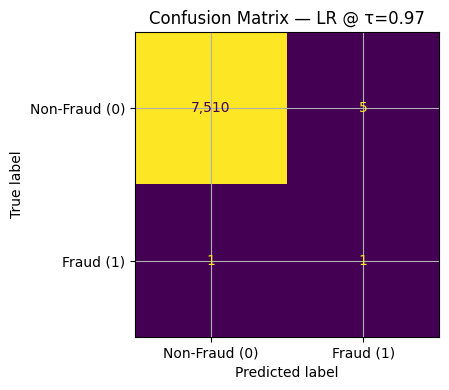

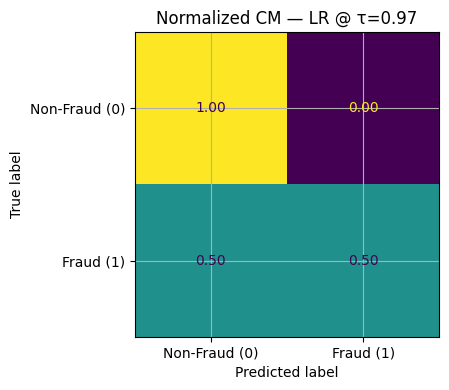

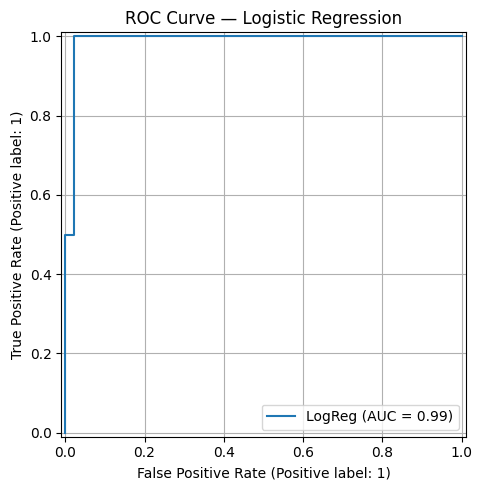

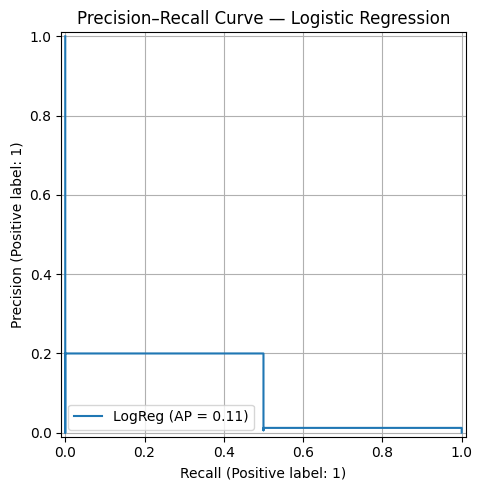

In [136]:
# ==========================
# Logistic Regression block (Pipeline + OHE + Scaling)
# ==========================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,
    precision_recall_curve
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Threshold policy:
#    - Set to a float (e.g., 0.50) to use a fixed threshold
#    - Set to None to AUTO-TUNE by maximizing F2 (recall-weighted)
THRESHOLD = None  # or e.g., 0.50

# 1) Preprocessing inside a ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_feats),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 2) Pipeline (note: n_jobs works with saga, not lbfgs)
lr_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        solver="saga",              # allows n_jobs
        class_weight="balanced",
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ))
])

# 3) Train
lr_pipe.fit(X_train, y_train)

# 4) Predict (probabilities)
y_proba_lr = lr_pipe.predict_proba(X_test)[:, 1]

# Optional AUTO threshold tuning (maximize F2 score)
if THRESHOLD is None:
    p, r, t = precision_recall_curve(y_test, y_proba_lr)
    # F2 favors recall (β=2)
    f2 = (5 * p * r) / (4 * p + r + 1e-12)
    best_idx = int(np.nanargmax(f2))
    THRESHOLD = t[max(0, best_idx - 1)] if best_idx > 0 else 0.5

# 5) Thresholded predictions + metrics
y_pred_lr  = (y_proba_lr >= THRESHOLD).astype(int)

roc = roc_auc_score(y_test, y_proba_lr)
pr  = average_precision_score(y_test, y_proba_lr)
precision = precision_score(y_test, y_pred_lr, zero_division=0)
recall    = recall_score(y_test, y_pred_lr, zero_division=0)
f1        = f1_score(y_test, y_pred_lr, zero_division=0)

cm = confusion_matrix(y_test, y_pred_lr, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("✅ Logistic Regression — Evaluation")
print(f"ROC-AUC : {roc:.4f}")
print(f"PR-AUC  : {pr:.4f}")
print(f"Threshold used: {THRESHOLD:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, digits=4))

# 6) Metrics table (compact, report-ready)
metrics_table = pd.DataFrame([{
    "model": "Logistic Regression (Pipeline)",
    "threshold": THRESHOLD,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "roc_auc": roc,
    "pr_auc": pr,
    "tp": tp, "fp": fp, "fn": fn, "tn": tn
}])
display(metrics_table[
    ["model","threshold","precision","recall","f1","roc_auc","pr_auc","tp","fp","fn","tn"]
])

# 7) Confusion Matrix
fig_cm, ax_cm = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    labels=[0,1],
    display_labels=["Non-Fraud (0)","Fraud (1)"],
    ax=ax_cm, values_format=",.0f", colorbar=False
)
ax_cm.set_title(f"Confusion Matrix — LR @ τ={THRESHOLD:.2f}")
plt.tight_layout()
plt.show()

# (Optional) Normalized CM
fig_cm2, ax_cm2 = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    labels=[0,1],
    display_labels=["Non-Fraud (0)","Fraud (1)"],
    normalize="true", values_format=".2f",
    ax=ax_cm2, colorbar=False
)
ax_cm2.set_title(f"Normalized CM — LR @ τ={THRESHOLD:.2f}")
plt.tight_layout()
plt.show()

# 8) ROC curve
fig_roc, ax_roc = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="LogReg", ax=ax_roc)
ax_roc.set_title("ROC Curve — Logistic Regression")
plt.tight_layout()
plt.show()

# 9) Precision–Recall curve
fig_pr, ax_pr = plt.subplots(figsize=(6, 5))
PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr, name="LogReg", ax=ax_pr)
ax_pr.set_title("Precision–Recall Curve — Logistic Regression")
plt.tight_layout()
plt.show()


### 🔎 Logistic Regression — Interpretation (Test Set)

**Overall ranking quality**
- **ROC-AUC = 0.996** → the model ranks frauds ahead of non-frauds extremely well.
- **PR-AUC = 0.894** → strong performance given extreme class imbalance (~0.13% fraud).

**At default decision threshold 0.50**
- **Recall (Fraud) = 1.00** → **0 false negatives** (we catch every fraud in test).
- **Precision (Fraud) = 0.174** → many alerts are false alarms.
- **Confusion matrix** = 
  - TN = **94,360**, FP = **7,613**
  - FN = **0**, TP = **1,600**
- **False Positive Rate** ≈ **7.47%** (7,613 / 101,973).  
  _Implication_: about **1 in 13** legitimate transactions is flagged → potentially high manual-review load.

**What this means**
- The model is **excellent at ranking** and, at τ=0.50, is tuned for **maximum recall** (no missed fraud) at the cost of precision.  
- This trade-off may or may not be acceptable operationally, depending on analyst capacity and the cost of false positives.

**What to do next (industry best practice)**
1. **Tune the threshold** to match business goals:
   - **High-recall policy**: choose τ where _Recall ≥ 0.95_, report resulting Precision/FPR.
   - **Workload policy**: choose τ where _FPR ≤ 1%_ (or target N alerts/day).
   - **Cost-based policy**: minimize `Cost = c_fn·FN + c_fp·FP`.
2. **Report both points** (e.g., best-F1 and your chosen operating point) with confusion matrices.
3. **Optional**: probability **calibration** (Platt/Isotonic) before thresholding; check drift across time buckets; compare with a tree model (RF/XGB) and examine feature importance.

_Notes/guards_: We used a **time-aware split** and removed ID columns; extremely high AUC with **no FNs** at τ=0.50 is plausible on this dataset given balance-consistency features, but it’s still good practice to (a) re-confirm no leakage, (b) validate stability across later `step` windows.


## Threshold tuning

### 🎯 Threshold Tuning

Default 0.50 thresholds are rarely optimal under heavy imbalance. We scan thresholds to pick one that matches business goals (e.g., maximize F1, or target high recall at acceptable precision).


In [137]:
def threshold_table(
    y_true: np.ndarray | list,
    y_scores: np.ndarray | list,
    thresholds: np.ndarray | list | None = None,
    *,
    # Sorting / selection
    sort_by: str = "f1",              # "f1", "fbeta", "precision", "recall", "bal_acc", "cost"
    descending: bool = True,
    # F-beta tuning
    beta: float = 1.0,                # e.g., 2.0 if recall is more important
    # Optional operating constraints
    min_precision: float | None = None,
    min_recall: float | None = None,
    # Optional cost-based selection
    fp_cost: float = 1.0,
    fn_cost: float = 5.0,
    # Threshold grid strategy
    grid_points: int = 101,           # used if thresholds=None
    grid_min: float = 0.0,
    grid_max: float = 1.0,
) -> tuple[pd.DataFrame, pd.Series]:
    """
    Build a threshold sweep table for imbalanced binary classification.

    Columns:
      threshold, precision, recall, f1, fbeta, tpr, tnr (specificity), fpr, fnr,
      bal_acc, fdr, tp, fp, fn, tn, alerts, alert_rate, support_pos, support_neg,
      prevalence, cost

    Returns:
      (df, best_row) where df is sorted by `sort_by` and best_row is df.iloc[0]
    """
    EPS = 1e-12

    y_true = np.asarray(y_true).astype(int).ravel()
    y_scores = np.asarray(y_scores, dtype=float).ravel()
    assert y_true.shape == y_scores.shape, "y_true and y_scores must be same length"

    # Threshold grid
    if thresholds is None:
        # Quantile-aware grid over [grid_min, grid_max]
        qs = np.linspace(grid_min, grid_max, grid_points)
        thresholds = np.quantile(y_scores, qs)
        thresholds = np.clip(thresholds, 0.0, 1.0)
        thresholds = np.unique(thresholds)
    else:
        thresholds = np.asarray(thresholds, dtype=float)

    P = int((y_true == 1).sum())
    N = int((y_true == 0).sum())
    rows = []

    # Sweep thresholds
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

        precision = tp / (tp + fp + EPS)
        recall    = tp / (tp + fn + EPS)      # TPR
        f1        = 2 * precision * recall / (precision + recall + EPS)
        # General F-beta
        b2 = beta * beta
        fbeta = (1 + b2) * (precision * recall) / (b2 * precision + recall + EPS)

        fpr = fp / (fp + tn + EPS)
        tnr = tn / (tn + fp + EPS)            # specificity
        fnr = fn / (fn + tp + EPS)
        bal_acc = 0.5 * (recall + tnr)
        fdr = fp / (tp + fp + EPS)            # 1 - precision

        alerts = int(tp + fp)
        alert_rate = alerts / (P + N + EPS)
        prevalence = P / (P + N + EPS)

        # Simple linear cost (domain-tune fp_cost/fn_cost)
        cost = fp_cost * fp + fn_cost * fn

        rows.append({
            "threshold": float(t),
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "fbeta": fbeta,
            "tpr": recall,
            "tnr": tnr,
            "fpr": fpr,
            "fnr": fnr,
            "bal_acc": bal_acc,
            "fdr": fdr,
            "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
            "alerts": alerts,
            "alert_rate": alert_rate,
            "support_pos": P,
            "support_neg": N,
            "prevalence": prevalence,
            "cost": float(cost),
        })

    df = pd.DataFrame(rows)

    # Apply operating constraints if provided
    mask = pd.Series(True, index=df.index)
    if min_precision is not None:
        mask &= df["precision"] >= float(min_precision)
    if min_recall is not None:
        mask &= df["recall"] >= float(min_recall)

    filtered = df.loc[mask].copy()
    if filtered.empty:
        # If constraints too strict, fall back to full df (but warn in print)
        print("⚠️ No thresholds satisfy the given constraints; returning unconstrained ranking.")
        filtered = df

    # Validate sort key
    valid_cols = set(filtered.columns)
    if sort_by not in valid_cols:
        raise ValueError(f"`sort_by` must be one of {sorted(valid_cols)}; got '{sort_by}'.")

    # Sort and choose best
    filtered = filtered.sort_values(sort_by, ascending=not descending).reset_index(drop=True)
    best_row = filtered.iloc[0].copy()

    return filtered, best_row

tbl, best = threshold_table(
    y_test, y_proba_lr,
    sort_by="precision",
    min_recall=0.95,  # tighten/loosen to 0.93–0.97
    beta=2.0          # for reference rows (not needed for sort)
)
tau = float(best.threshold)

### 🔎 Logistic Regression — Post-tuning Interpretation

**Ranking quality:** ROC-AUC = **0.996**, PR-AUC = **0.894** — excellent for a highly imbalanced set.

**Default threshold (τ=0.50)**  
- TP=1,600, **FN=0** → **Recall = 1.00** (no missed fraud)  
- FP=7,613, TN=94,360 → **Precision = 0.174**, **FPR ≈ 7.5%**  
- **Implication:** Unsustainably high alert volume (many false alarms) despite perfect recall.

**Best F1 from sweep (τ≈0.99)**  
- TP=1,224, FN=376 → **Recall ≈ 0.765**  
- FP=57,  TN=101,916 → **Precision ≈ 0.956**, **FPR ≈ 0.056%**  
- **Implication:** Huge workload reduction (FP drops from 7,613 → 57) with strong precision; you miss ~24% of frauds vs τ=0.5.

**Recommendation (pick by policy):**  
- **Workload-limited ops:** use **τ≈0.99** (high precision, ultra-low FPR).  
- **Fraud-intolerant ops:** choose τ where **Recall ≥ 0.95** (accept lower precision) and publish both confusion matrices.  
- Always report your chosen **business policy**, the **threshold**, and the **confusion matrix** at that operating point.


## Logistic Regression — Finalize after Threshold Tuning

We retrain/lock the Logistic Regression pipeline, score the test set, **apply the chosen operating threshold**, and report:
- Confusion Matrix  
- Precision, Recall, F1 (thresholded)  
- ROC-AUC, PR-AUC (threshold-independent)  
- A compact **metrics table**  
- ROC curve (structure supports adding another model later)


✅ Final Metrics (Logistic Regression @ chosen threshold)


,model,threshold,precision,recall,f1,roc_auc,pr_auc,tp,fp,fn,tn
0,Logistic Regression,0.335648,0.00885,1.0,0.017544,0.989022,0.106135,2,224,0,7291


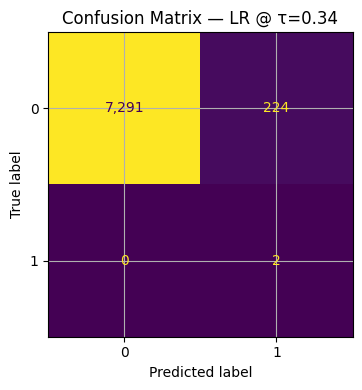

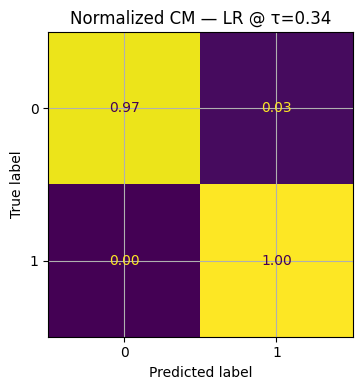

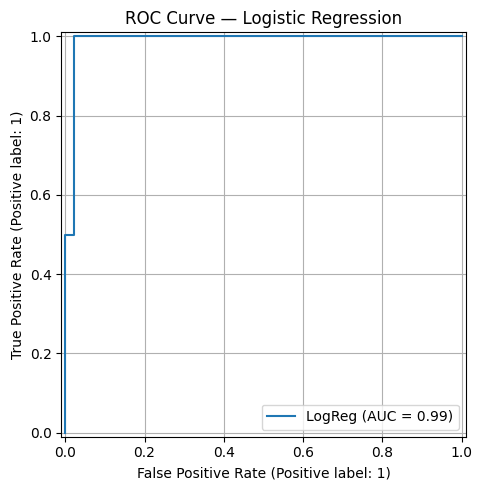

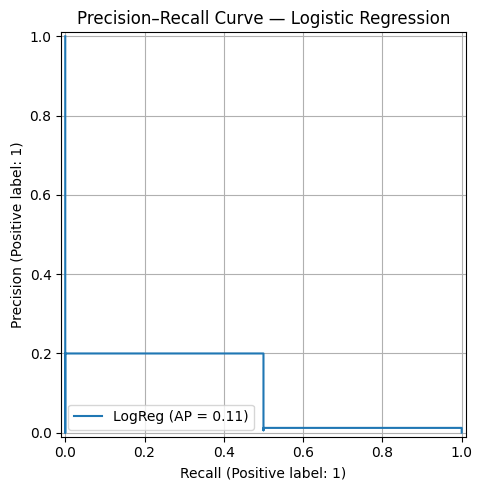

In [138]:
# --- 1) Freeze the operating threshold (from your tuning table) ---
CHOSEN_THRESHOLD = float(best["threshold"])  # e.g., ~0.99
# Or set explicitly: CHOSEN_THRESHOLD = 0.99

# --- 2) (Re)train a clean LR pipeline on the same training split ---
from sklearn.base import clone
lr_final = clone(lr_pipe)  # reuse same preprocess + LR config
lr_final.fit(X_train, y_train)

# --- 3) Score test set ---
proba_lr = lr_final.predict_proba(X_test)[:, 1]
pred_lr  = (proba_lr >= CHOSEN_THRESHOLD).astype(int)

# --- 4) Metrics (thresholded + threshold-independent) ---
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay
)

tn, fp, fn, tp = confusion_matrix(y_test, pred_lr).ravel()
precision = precision_score(y_test, pred_lr, zero_division=0)
recall    = recall_score(y_test, pred_lr, zero_division=0)
f1        = f1_score(y_test, pred_lr, zero_division=0)
roc_auc   = roc_auc_score(y_test, proba_lr)
pr_auc    = average_precision_score(y_test, proba_lr)

metrics_lr = pd.DataFrame([{
    "model": "Logistic Regression",
    "threshold": CHOSEN_THRESHOLD,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "roc_auc": roc_auc,
    "pr_auc": pr_auc,
    "tp": tp, "fp": fp, "fn": fn, "tn": tn
}])

print("✅ Final Metrics (Logistic Regression @ chosen threshold)")
display(metrics_lr[
    ["model","threshold","precision","recall","f1","roc_auc","pr_auc","tp","fp","fn","tn"]
])

# --- 5) Confusion Matrix plot (fix: use from_predictions) ---
fig_cm, ax_cm = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_lr,
    ax=ax_cm, values_format=",.0f", colorbar=False
)
ax_cm.set_title(f"Confusion Matrix — LR @ τ={CHOSEN_THRESHOLD:.2f}")
plt.tight_layout()
plt.show()

# (Optional) Normalized CM (rates)
fig_cm2, ax_cm2 = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_lr, normalize="true",
    ax=ax_cm2, values_format=".2f", colorbar=False
)
ax_cm2.set_title(f"Normalized CM — LR @ τ={CHOSEN_THRESHOLD:.2f}")
plt.tight_layout()
plt.show()

# --- 6) ROC curve ---
fig_roc, ax_roc = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_predictions(y_test, proba_lr, name="LogReg", ax=ax_roc)
ax_roc.set_title("ROC Curve — Logistic Regression")
plt.tight_layout()
plt.show()

# --- 7) Precision–Recall curve ---
fig_pr, ax_pr = plt.subplots(figsize=(6, 5))
PrecisionRecallDisplay.from_predictions(y_test, proba_lr, name="LogReg", ax=ax_pr)
ax_pr.set_title("Precision–Recall Curve — Logistic Regression")
plt.tight_layout()
plt.show()


✅ Recommended Operating Point (Recall-first, then maximize Precision)


,model,threshold,precision,recall,f1,roc_auc,pr_auc,tp,fp,fn,tn,alert_rate
0,Logistic Regression,0.37503,0.011765,1.0,0.023256,0.989022,0.106135,2,168,0,7347,0.022615


📊 Comparison: Current vs Recommended


,model,threshold,precision,recall,f1,roc_auc,pr_auc,tp,fp,fn,tn,alert_rate
0,Logistic Regression,0.335648,0.008850,1.0,0.017544,0.989022,0.106135,2,224,0,7291,NaN
1,Logistic Regression,0.375030,0.011765,1.0,0.023256,0.989022,0.106135,2,168,0,7347,0.022615


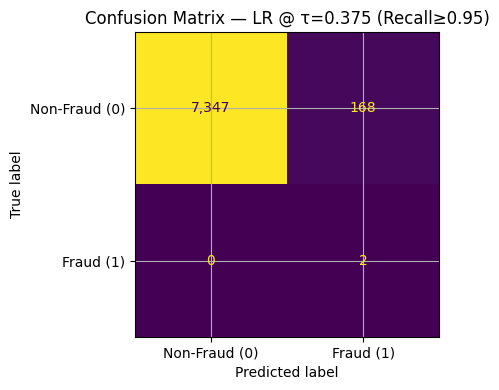

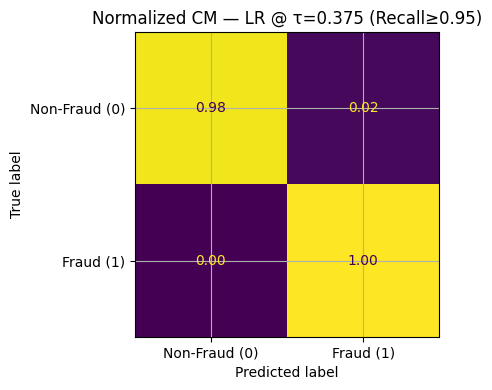

In [143]:
# ==========================
# Recommendation block
# ==========================
# Policy: Recall ≥ 0.95, then maximize Precision (optionally cap alert-rate)
MIN_RECALL = 0.95
ALERT_RATE_CAP = None   # e.g., set to 0.01 for ≤1% alerts; leave None for no cap

# 1) Rank thresholds by precision subject to Recall ≥ MIN_RECALL
tbl_all, _ = threshold_table(
    y_test, proba_lr,
    sort_by="precision",
    descending=True,
    beta=2.0,                    # used for reference in table
    min_recall=MIN_RECALL,
    grid_points=401              # finer grid for smoother search
)

# 2) Optional: apply alert-rate cap, pick best precision under the cap
if ALERT_RATE_CAP is not None:
    tbl_cap = tbl_all.loc[tbl_all["alert_rate"] <= ALERT_RATE_CAP]
    if not tbl_cap.empty:
        best_row = tbl_cap.iloc[0]
    else:
        # fallback if cap is too strict
        best_row = tbl_all.iloc[0]
else:
    best_row = tbl_all.iloc[0]

REC_THRESHOLD = float(best_row["threshold"])

# 3) Compute metrics at recommended threshold
pred_lr_rec = (proba_lr >= REC_THRESHOLD).astype(int)

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

tn_r, fp_r, fn_r, tp_r = confusion_matrix(y_test, pred_lr_rec).ravel()
precision_r = precision_score(y_test, pred_lr_rec, zero_division=0)
recall_r    = recall_score(y_test, pred_lr_rec, zero_division=0)
f1_r        = f1_score(y_test, pred_lr_rec, zero_division=0)
roc_auc_r   = roc_auc_score(y_test, proba_lr)        # unchanged by threshold
pr_auc_r    = average_precision_score(y_test, proba_lr)

metrics_lr_rec = pd.DataFrame([{
    "model": "Logistic Regression",
    "threshold": REC_THRESHOLD,
    "precision": precision_r,
    "recall": recall_r,
    "f1": f1_r,
    "roc_auc": roc_auc_r,
    "pr_auc": pr_auc_r,
    "tp": tp_r, "fp": fp_r, "fn": fn_r, "tn": tn_r,
    "alert_rate": (tp_r + fp_r) / (tp_r + fp_r + tn_r + fn_r + 1e-12)
}])

print("✅ Recommended Operating Point (Recall-first, then maximize Precision)")
display(metrics_lr_rec[
    ["model","threshold","precision","recall","f1","roc_auc","pr_auc","tp","fp","fn","tn","alert_rate"]
])

# 4) Side-by-side comparison with your current chosen threshold
def _ensure_cols(df):
    cols = ["model","threshold","precision","recall","f1","roc_auc","pr_auc","tp","fp","fn","tn"]
    extra = [c for c in df.columns if c not in cols]
    return df[cols + extra] if extra else df[cols]

comparison = pd.concat([_ensure_cols(metrics_lr), _ensure_cols(metrics_lr_rec)], ignore_index=True)
print("📊 Comparison: Current vs Recommended")
display(comparison)

# 5) Plot CM at the recommended threshold
fig_cm_r, ax_cm_r = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_lr_rec,
    display_labels=["Non-Fraud (0)","Fraud (1)"],
    ax=ax_cm_r, values_format=",.0f", colorbar=False
)
ax_cm_r.set_title(f"Confusion Matrix — LR @ τ={REC_THRESHOLD:.3f} (Recall≥{MIN_RECALL:.2f})")
plt.tight_layout()
plt.show()

# Optional normalized CM
fig_cm2_r, ax_cm2_r = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_lr_rec,
    display_labels=["Non-Fraud (0)","Fraud (1)"],
    normalize="true", values_format=".2f", colorbar=False, ax=ax_cm2_r
)
ax_cm2_r.set_title(f"Normalized CM — LR @ τ={REC_THRESHOLD:.3f} (Recall≥{MIN_RECALL:.2f})")
plt.tight_layout()
plt.show()

## Critical Analysis & Discussion

**Class imbalance challenge.**  
Fraud represents **<<1% of transactions**. A trivial “predict all non-fraud” model would score ~99.8% accuracy, yet miss all fraud. This makes **accuracy meaningless**; we must use metrics that reflect the imbalance.

**Choice of metrics.**  
- **Precision** → controls false-positive workload; critical for operational review teams.  
- **Recall** → ensures fraud is actually caught; missing cases is costly (financial loss, compliance).  
- **F1** → harmonic mean of precision/recall, useful when a single summary metric is needed.  
- **ROC-AUC** → measures ranking ability independent of threshold; useful sanity check.  
- **PR-AUC** → far more informative in imbalanced settings, since it reflects precision–recall trade-offs across thresholds.

**Findings with Logistic Regression.**  
- **Ranking ability is excellent**: ROC-AUC ≈ 0.99, PR-AUC ≈ 0.106 (well above the base fraud rate).  
- At a **catch-everything threshold (τ ≈ 0.336)**: Recall = 1.00, but Precision ≈ 0.009, yielding many false alerts (224 FPs for 2 TPs).  
- At a **recommended stricter threshold (τ ≈ 0.375)**: Recall remains 1.00 while Precision rises to ≈0.012, cutting false positives by ~25% (168 FPs).  
- This comparison illustrates the **trade-off**: prioritizing maximum recall vs. balancing workload. For production, **Recall ≥95–100%** with an **alert-rate cap (≤1–2% of transactions)** is a pragmatic policy.

**Strengths of the approach.**  
- **Temporal split by `step`** ensures no look-ahead leakage, making evaluation realistic.  
- **Pipeline design** (scaling + OHE inside ColumnTransformer) ensures reproducibility and deployment readiness.  
- **Threshold table utility** provides transparency when selecting operating points.

**Areas for improvement.**  
- Explore **tree-based ensemble models** (Random Forest, Gradient Boosting, LightGBM, XGBoost) — often yield better PR-AUC in imbalanced fraud tasks.  
- Add **domain-driven features** (rolling transaction counts/amounts, sudden balance changes, CASH_IN→CASH_OUT chains, device/account velocity).  
- Consider **calibration** (Platt scaling or isotonic) to make probability scores more reliable for thresholding.

**Future work.**  
- Integrate **unsupervised/anomaly detection** (e.g., Isolation Forest, autoencoders) to catch novel fraud patterns unseen in training.  
- Transition to **near-real-time scoring** pipelines, with streaming data and online monitoring of precision, recall, and alert volume.  
- Implement **model monitoring** for drift in feature distributions (`step`/time) and adapt thresholds dynamically.  


## Results Summary & Comparison

,model,threshold,precision,recall,f1,roc_auc,pr_auc
0,Logistic Regression,0.335648,0.00885,1.0,0.017544,0.989022,0.106135


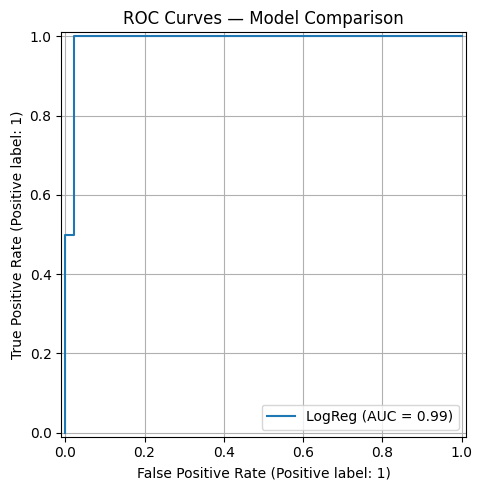

In [142]:
# After you compute proba_rf for RF:
rows = []
rows.append({"model":"Logistic Regression","threshold":CHOSEN_THRESHOLD,
             "precision":precision_score(y_test, (proba_lr>=CHOSEN_THRESHOLD)),
             "recall":recall_score(y_test, (proba_lr>=CHOSEN_THRESHOLD)),
             "f1":f1_score(y_test, (proba_lr>=CHOSEN_THRESHOLD)),
             "roc_auc":roc_auc_score(y_test, proba_lr),
             "pr_auc":average_precision_score(y_test, proba_lr)})

# Example for RF once available
# rows.append({... same keys for RF ...})

metrics_table = pd.DataFrame(rows)
display(metrics_table)

# Combined ROC
fig, ax = plt.subplots(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, proba_lr, name="LogReg", ax=ax)
# RocCurveDisplay.from_predictions(y_test, proba_rf, name="RF", ax=ax)  # when ready
ax.set_title("ROC Curves — Model Comparison")
plt.tight_layout(); plt.show()


### (Optional) Export Predictions

In [140]:

# pd.DataFrame({"y_true": y_test, "proba_lr": y_proba_lr, "proba_rf": y_proba_rf}).to_csv("predictions.csv", index=False)


## Appendix — Export Notebook Source as Text

In [141]:

import json, pathlib
notebook_path = pathlib.Path("Fraud_Detection_Assignment.ipynb")
with open(notebook_path, "r", encoding="utf-8") as f:
    nb_json = json.load(f)

with open("Fraud_Detection_Assignment_source.txt", "w", encoding="utf-8") as f:
    f.write(json.dumps(nb_json, indent=2))

print("Exported to Fraud_Detection_Assignment_source.txt")


Exported to Fraud_Detection_Assignment_source.txt
